# Property Prediction with Machine Learning

Machine learning, particularly deep learning, has recently made significant advancements in bottom-up mass spectrometry proteomics. One of its most impactful applications is the prediction of various peptide or ion properties. Key prediction tasks include:

* Retention time prediction
* Ion mobility prediction
* Fragment ion intensity prediction

With the increasing availability of models and frameworks, Python has become the go-to interface, thanks to its robust ecosystem of machine learning libraries such as TensorFlow, PyTorch, and JAX.

This notebook provides a hands-on example using the `imspy` library to predict peptide and ion properties. `imspy` utilizes a [Prosit model](https://www.nature.com/articles/s41467-024-48322-0), which is optimized for timsTOF data, to predict fragment ion intensity.

You can easily adapt this notebook for non-timsTOF datasets by replacing the first cell with your own data import and creating PSMs using the `sagepy` library.

In this tutorial, you will:

* Read an ion-mobility DDA dataset
* Perform retention time, ion mobility, and fragment intensity prediction
* Serialize to disk

## Read raw data
Start by downloading the data from [JPOST](https://repository.jpostdb.org/entry/JPST002158), e.g., the dataset `M210115_001_Slot1-1_1_850.d.rar` and unpack it into a directory of your choice.

In [2]:
from imspy.timstof import extract_timstof_dda_data

# This function will extract raw timsTOF dda data and generate a ready-to-score dataset from it, data read in can take a minute or two
# CAUTION: Currently, MAC-OS is not supported by bruker binaries, so this might fail if you are on MAC
raw_data = extract_timstof_dda_data(
    path="/media/hd01/CCSPred/HELA-GRAD110/M210115_001_Slot1-1_1_850.d",
    in_memory=False,
    use_bruker_sdk=True,
)

/home/administrator/Documents/promotion/ENV-11/lib/python3.11/site-packages/imspy/timstof/dda.py:71: UserWarning: Using multiple threads is currently not supported when using Bruker SDK, setting num_threads to 1.
  warnings.warn("Using multiple threads is currently not supported when using Bruker SDK, "


## Generate initial PSMs

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sagepy.utility import create_sage_database

fasta_path = "/media/hd02/data/fasta/hela/plain/uniprotkb_proteome_UP000005640_AND_revi_2024_05_21.fasta"

static_mods = {"C": "[UNIMOD:4]"}
variable_mods = {"M": ["[UNIMOD:1]", "[UNIMOD:35]"], "[": ["[UNIMOD:1]"]}

indexed_database = create_sage_database(
    fasta_path = fasta_path,
    static_mods = static_mods,
    variable_mods = variable_mods,
    min_len=8,
    # Prosit can handle sequences up to a length of 30, so we set this as the max number of AAs
    max_len=30,
)

In [5]:
from sagepy.core import Scorer

# create a scorer
scorer = Scorer(report_psms=5, min_matched_peaks=5, static_mods=static_mods, variable_mods=variable_mods)

# generate a collection of psms
psms = scorer.score_collection_psm(
    db=indexed_database, 
    spectrum_collection=raw_data.processed_spec.values,
    num_threads=16,
)

In [6]:
# the prediction modules all expect list of psms, so we flatten the returned dict into a list
psm_list = []

for psm_id, matches in psms.items():
    psm_list.extend(matches)

In [7]:
from imspy.algorithm import predict_retention_time
predict_retention_time(psm_collection=psm_list, refine_model=True, verbose=False)

2025-01-06 14:41:47.708636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-06 14:41:47.863908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-06 14:41:47.867273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

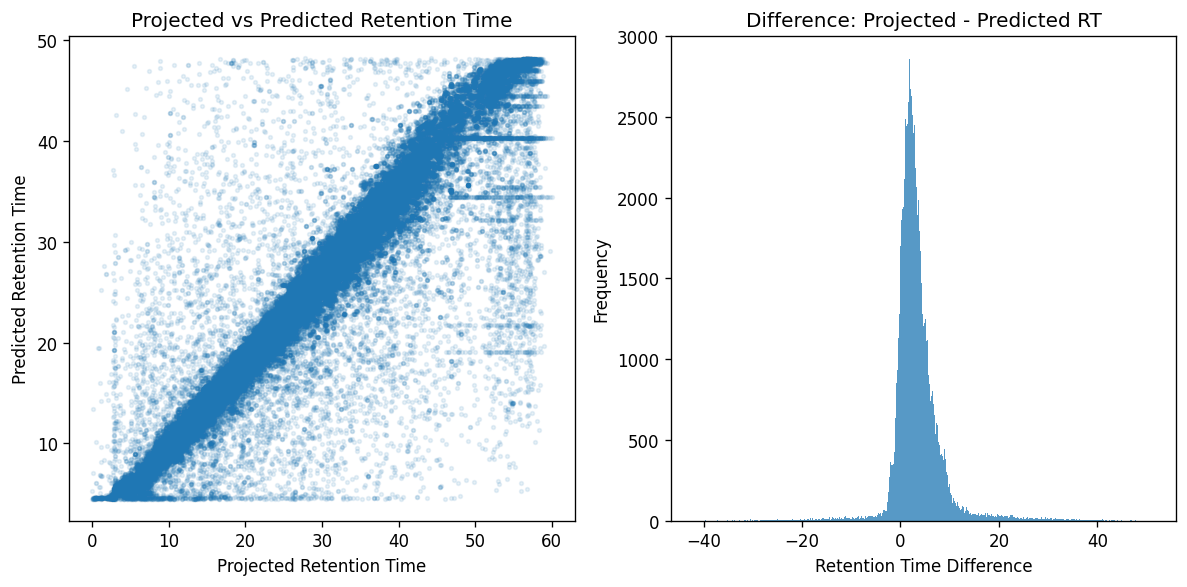

In [10]:
projected_rt = [x.retention_time_projected for x in psm_list]
retention_time_predicted = [x.retention_time_predicted for x in psm_list]
rt_difference = [x.retention_time_projected - x.retention_time_predicted for x in psm_list]

# Create a figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=120)

ax1.scatter(projected_rt, retention_time_predicted, alpha=0.1, s=5)
ax1.set_title("Projected vs Predicted Retention Time")
ax1.set_xlabel("Projected Retention Time")
ax1.set_ylabel("Predicted Retention Time")

ax2.hist(rt_difference, bins="auto", alpha=0.75)
ax2.set_title("Difference: Projected - Predicted RT")
ax2.set_xlabel("Retention Time Difference")
ax2.set_ylabel("Frequency")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [11]:
from imspy.algorithm import predict_inverse_ion_mobility
predict_inverse_ion_mobility(psm_collection=psm_list, refine_model=True, verbose=False)

In [16]:
psm_list[0].sage_feature.predicted_ims

0.9994869828224182

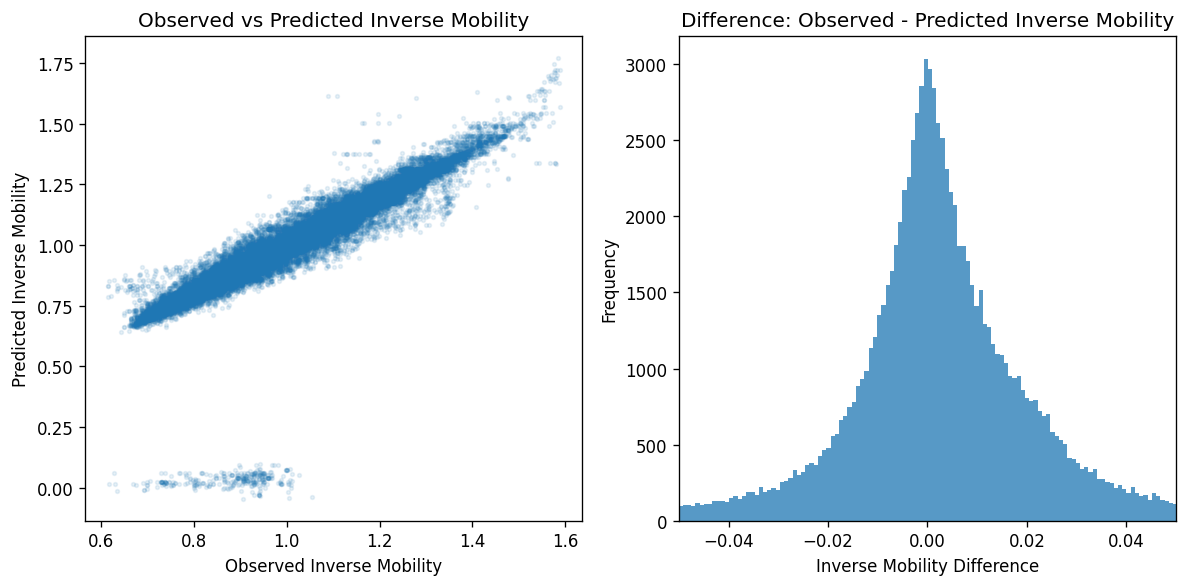

In [17]:
inverse_mobility_observed = [x.sage_feature.ims for x in psm_list]
inverse_mobility_predicted = [x.sage_feature.predicted_ims for x in psm_list]
mobility_difference = [x.sage_feature.ims - x.sage_feature.predicted_ims for x in psm_list]

# Create a figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=120)

ax1.scatter(inverse_mobility_observed, inverse_mobility_predicted, alpha=0.1, s=5)
ax1.set_title("Observed vs Predicted Inverse Mobility")
ax1.set_xlabel("Observed Inverse Mobility")
ax1.set_ylabel("Predicted Inverse Mobility")

ax2.hist(mobility_difference, bins="auto", alpha=0.75)
ax2.set_title("Difference: Observed - Predicted Inverse Mobility")
ax2.set_xlabel("Inverse Mobility Difference")
ax2.set_ylabel("Frequency")
ax2.set_xlim([-0.05, 0.05])

plt.tight_layout()
plt.show()

## Predict intensities

In [18]:
from imspy.algorithm import predict_intensities_prosit

# this will add predicted intensities to every PSM and also add the cosine similarity between predicted and observed spectra
predict_intensities_prosit(psm_collection=psm_list)

/home/administrator/Documents/promotion/ENV-11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/administrator/Documents/promotion/ENV-11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Serialize PSMs to disk
You can actually use any format you like, conveniently, sagepy has a binary json serializaton available that you can use if you want:

In [45]:
from sagepy.utility import compress_psms

# creates an array of bytes
psm_bin = compress_psms(psm_list)

with open("psms.bin", "wb") as outfile:
    outfile.write(bytearray(psm_bin))
outfile.close()